### Carnot cycle problem:

  Consider the following heat engine:

  1.  pseudo-adiabatic ascent in the tropical Pacific, surface pressure = 1000 hPa, where the SST is 300 K and
      the relative humidity is 80%.  Air rises to 400 hPa and loses 80% of its liquid water

  2.  Cooling at a constant pressure of 400 hPa by 20 K, with no change in total water

  3.  Descent to 1000 hPa, conserving water

  Do the following in a notebook:

  1\. Use makeSkewWet to  draw this cycle on a tephigram, using carnot.py and the midterm solution notebook as guidance.

  2\. Calculate the change in enthalpy at the surface and at 400 hPa, including both sensible and latent heat terms.

  3\. Find the total work done by the engine, and its efficiency.

  4\. Find the percentage of the total heat change that is due to addition and remove of water
     during the cycle.





In [199]:
from matplotlib import pyplot as plt
import numpy as np
from importlib import reload
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet
from a405thermo.thermlib import find_esat, find_Td,find_thetaet,find_lcl,tinvert_thetae
from a405thermo.thermlib import find_lv, find_rsat
from a405thermo.thermlib import convertTempToSkew
from a405thermo.constants import constants as c
from a405utils.helper_funs import make_tuple

### A. get the surface enthalpy in the tropics (point A)

In [200]:
def calc_enthalpy(point_dict):
    """
    Calculate the enthalpy and total water mixing ratio
    for an air parcel, given a dictionary or parameters

    Parameters
    ----------
    
    point_dict: dictionary
              dictionary with the following keys
              ['id','temp','rv','rl','press']
          units: point letter, K  kg/kg kg/kg Pa 
    
    Returns
    -------
    
    vals: named tuple
         tuple with dictionary values plus rt (kg/kg)  and enthalpy (J/kg)
    """
    point_dict['rt'] = point_dict['rv'] + point_dict['rl']
    vals = make_tuple(point_dict)
    cp = c.cpd + vals.rt*c.cl
    point_dict['enthalpy'] =  cp*vals.temp + find_lv(vals.temp)*vals.rv
    vals = make_tuple(point_dict)
    return vals

def format_tup(the_tup):
    """
    format a tuple returned from calc_enthalpy for output
    """
    the_string="""
    point {id:}
    temp: {temp:6.3f} K
    press: {press:6.3g} Pa
    rv:  {rv:6.3g} kg/kg
    rl:  {rl:6.3g} kg/kg
    rt:  {rt:6.3g} kg/kg
    enthalpy: {enthalpy: 8.3g}  J/kg
    """
    return the_string.format_map(the_tup._asdict())
    
   
%matplotlib inline
pa2hPa = 1.e-2

A_press = 1.e5  #Pa
B_press = 4.e4  #Pa
A_temp = 300  #K
RH = 0.8
e = find_esat(A_temp)*RH
A_rv = c.eps*e/(A_press - e)
A_Td = find_Td(A_rv,A_press)
print('tropical surface dewpoint: {} K'.format(A_Td))
A_thetae=find_thetaet(A_Td,A_rv,A_temp,A_press)
print('tropical surface thetae: {} K'.format(A_thetae))
A_temp,A_rv,A_rl = tinvert_thetae(A_thetae,A_rv,A_press)
fields=['id','temp','rv','rl','press']
A_dict = dict(zip(fields,('A',A_temp,A_rv,A_rl,A_press)))
A_tup = calc_enthalpy(A_dict)
print(format_tup(A_tup))

tropical surface dewpoint: 296.2618676251417 K
tropical surface thetae: 349.3616804125229 K

    point A
    temp: 300.000 K
    press:  1e+05 Pa
    rv:  0.0181 kg/kg
    rl:       0 kg/kg
    rt:  0.0181 kg/kg
    enthalpy:  3.71e+05  J/kg
    


### B. Lift to 400 hPa and remove 80% of the liquied water


    point B
    temp: 263.033 K
    press:  4e+04 Pa
    rv:  0.00445 kg/kg
    rl:  0.00273 kg/kg
    rt:  0.00718 kg/kg
    enthalpy:  2.83e+05  J/kg
    


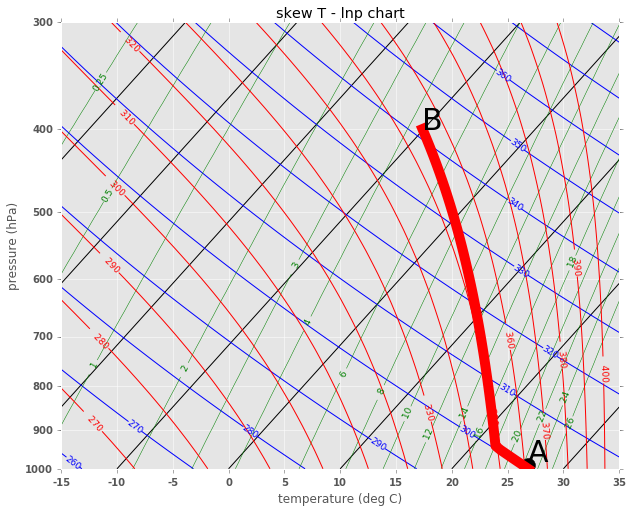

In [201]:
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=[10,8])
ax,skew = makeSkewWet(ax,corners=[-15,35])

lcl_temp, lcl_press = find_lcl(A_Td,A_tup.temp,A_tup.press)
xplot=convertTempToSkew(A_tup.temp - c.Tc,A_tup.press*pa2hPa,skew)
bot=ax.plot(xplot, A_tup.press*pa2hPa-10., 'ko', markersize=14, markerfacecolor='k')
ax.text(xplot,A_tup.press*pa2hPa-20.,'A',fontsize=30)
pressrange=np.arange(1000,395.,-10.)
trop_adiabat=[]
for press in pressrange:
    temp,rv,rl = tinvert_thetae(A_thetae,A_tup.rt,press*1.e2)
    xtemp = convertTempToSkew(temp - c.Tc,press,skew)
    trop_adiabat.append(xtemp)
ax.plot(trop_adiabat,pressrange,'r-',lw=10)
B_press=400.e2  #Pa
temp,rv,rl = tinvert_thetae(thetae_trop,A_tup.rt,B_press)
rl = 0.2*rl  #rain out 80% of liquid
B_dict = dict(zip(fields,('B',temp,rv,rl,B_press)))
ax.text(trop_adiabat[-1],B_press*pa2hPa,'B',fontsize=30)
B_tup = calc_enthalpy(B_dict)
print(format_tup(B_tup))


    point C
    temp: 241.210 K
    press:  4e+04 Pa
    rv:  0.00066 kg/kg
    rl:  0.00652 kg/kg
    rt:  0.00718 kg/kg
    enthalpy:  2.51e+05  J/kg
    


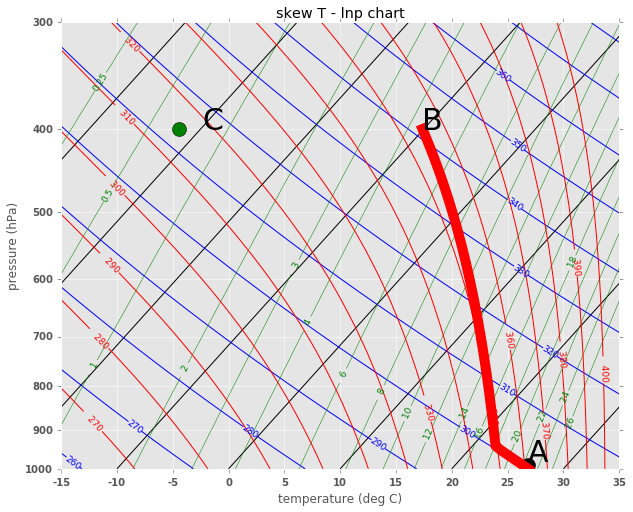

In [202]:
top_temp,top_rv,top_rl = tinvert_thetae(A_thetae,B_tup.rt,B_tup.press)
C_temp = top_temp - 20.
C_rt = B_tup.rt  #conserve total water from B to C
C_rv = find_rsat(C_temp,B_tup.press) 
C_rl = C_rt - C_rv  #cool and condense more liquid with constant rt

C_dict = dict(zip(fields,('C',C_temp,C_rv,C_rl,B_tup.press)))
C_tup = calc_enthalpy(C_dict)
C_thetae = find_thetaet(C_tup.temp,C_tup.rt,C_tup.temp,B_tup.press)
xplot=convertTempToSkew(C_tup.temp - c.Tc,C_tup.press*pa2hPa,skew)
top=ax.plot(xplot, C_tup.press*pa2hPa, 'ko', markersize=14, markerfacecolor='g')
ax.text(xplot*0.99, C_tup.press*pa2hPa,'C',fontsize=30)
print(format_tup(C_tup))
display(fig)

### D. descend adiabatically to surface


    point D
    temp: 293.124 K
    press:  1e+03 Pa
    rv:  0.00718 kg/kg
    rl:       0 kg/kg
    rt:  0.00718 kg/kg
    enthalpy:  3.22e+05  J/kg
    


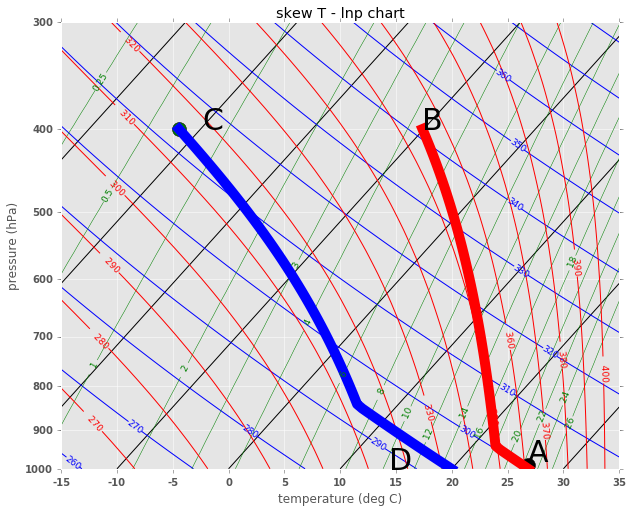

In [203]:
C_adiabat=[]
for press in pressrange:
    temp,rv,rl = tinvert_thetae(C_thetae,C_tup.rt,press*1.e2)
    xtemp = convertTempToSkew(temp - c.Tc,press,skew)
    C_adiabat.append(xtemp)
#
# now go to the surface
#
press=1000.
temp,rv,rl = tinvert_thetae(C_thetae,C_tup.rt,press*1.e2)
D_dict = dict(zip(fields,('D',temp,rv,rl,press)))
D_tup = calc_enthalpy(D_dict)
ax.plot(C_adiabat,pressrange,'b-',lw=10)
ax.text(C_adiabat[0]*1.03,pressrange[0],'D',fontsize=30)
print(format_tup(D_tup))
display(fig)

In [204]:
### Enthalpy change from D to A

deltaT_AD = A_tup.temp - D_tup.temp
deltaRv_AD = A_tup.rv - D_tup.rv
print('from D to A, temp increases by {:5.3f} K, vapor by {:5.3f} g/kg'\
      .format(deltaT_AD,deltaRv_AD*1.e3))

deltaT_BC = B_tup.temp - C_tup.temp
deltaRv_BC = B_tup.rv - C_tup.rv

#print(B_tup)
#print(C_tup)
print('from B to C, temp decreases by {:5.3f} K, vapor by {:5.3f} g/kg'\
      .format(deltaT_BC,deltaRv_BC*1.e3))


deltaQin = A_tup.enthalpy - D_tup.enthalpy

### enthalpy change from B to C

deltaQout = B_tup.enthalpy - C_tup.enthalpy
print("deltaQin {:6.4g} J/kg\ndeltaQout {:6.4g}  J/kg".format(deltaQin,deltaQout))
deltaQinVap = 2.5e6*(A_tup.rv - D_tup.rv)
deltaQoutVap = 2.5e6*(B_tup.rv - C_tup.rv)
print("deltaQin due to vapor= {:6.4g} J/kg = {:6.2f}%".format(deltaQinVap,deltaQinVap/deltaQin*100.))
print("deltaQout due to vapor= {:6.4g} J/kg = {:6.2f}%".format(deltaQoutVap,deltaQoutVap/deltaQout*100.))
efficiency = (deltaQin - deltaQout)/deltaQin
print('heat engine efficiency is {:6.3g} %'.format(efficiency*100.))



from D to A, temp increases by 6.876 K, vapor by 10.920 g/kg
from B to C, temp decreases by 21.823 K, vapor by 3.789 g/kg
deltaQin 4.895e+04 J/kg
deltaQout 3.203e+04  J/kg
deltaQin due to vapor= 2.73e+04 J/kg =  55.77%
deltaQout due to vapor=   9474 J/kg =  29.58%
heat engine efficiency is   34.6 %
